#Get to know our data
In this script we apply preprocessing steps to the 2 original .tmx files of our general purpose dataset TED2020 v1. We use the following combinations : en_el, el_ru (assuming English is the source language), in order to create a parallel corpus of 3 languages.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#TMX_parsing + dataframe creation

In [ ]:
import xml.etree.ElementTree as ET
import pandas as pd
import re
import matplotlib.pyplot as plt

In [ ]:
# Parse the TMX file
tree = ET.parse('/content/drive/MyDrive/Machine_Translation/generic_unprocessed/el-en.tmx')
root = tree.getroot()

In [ ]:
# Initialize counters for source and target elements
source_count = 0
target_count = 0

source = []
target = []

# Define the XML namespace
xml_namespace = 'http://www.w3.org/XML/1998/namespace'

# Iterate through translation units and extract source and target text. We suppose that the Source language is English and the target is eithe Greek or Russan
for tu in root.findall('.//tu'):
    source_tuv = tu.find('.//tuv[@{%s}lang="en"]/seg' % xml_namespace)
    target_tuv = tu.find('.//tuv[@{%s}lang="el"]/seg' % xml_namespace)

    if source_tuv is not None:
        source_text = source_tuv.text
        source_count += 1
        source.append(source_text)

    if target_tuv is not None:
        target_text = target_tuv.text
        target_count += 1
        target.append(target_text)

# Print the total number of source and target elements
print('Number of Source Elements:', source_count)
print('Number of Target Elements (Greek):', target_count)


# We work with dataframes
# Our column names
column_names = ['Source', 'Target_el']

# Create a DataFrame
data = list(zip(source, target))
df = pd.DataFrame(data, columns=column_names)

# We keep the orgnal dataframe and will apply clearance to its copy
df1 = df.copy()

df.info()

Number of Source Elements: 262659
Number of Target Elements (Greek): 262659
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262659 entries, 0 to 262658
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Source     262658 non-null  object
 1   Target_el  262658 non-null  object
dtypes: object(2)
memory usage: 4.0+ MB


**Important**: We apply the preprocessing steps to a COPY (df1) of the original dataframe (df).This is done in order to first decide the sentence-pairs to be kept and then based on their indexes to merge them with the el_ru .tmx file.
We see that the original .tmx for en_el contains **262,659 sentences pairs**. This won't be the case for el_ru, but we show you how we handle this in later steps.

#Functions

In [ ]:
# Function to split sentences into words
def split_sentence(sentence):
    if isinstance(sentence, str):
        return sentence.split()
    else:
        return []

# Function to count words in a sentence (before tokenization)
def count_words(sentence):
    if sentence is None:
        return 0
    return len(sentence.split())

# Function to count tokenized words in a list
def count_tokenized_words(word_list):
    if word_list is None:
        return 0
    return len(word_list)

# Function to find phrases within parentheses in a sentence (before tokenization)
def find_phrases_in_parentheses(sentence):
    if isinstance(sentence, str):
        phrases_in_parentheses = re.findall(r'\((.*?)\)', sentence)
        return phrases_in_parentheses
    else:
        return []

#Function to remove extra extra spacing between words of a sentence.
def clean_text(text):
    if isinstance(text, str):
      text = re.sub(r"\s+", " ", text).strip()
      return text
    else:
        return []

# Function to check if the first letter of a word is capitalized
def is_first_letter_capitalized(word):
    return word[0].isupper()

# Function to check if a string contains Latin characters
def contains_latin(text):
    if text is None:
        return False  # Handle None values
    elif not isinstance(text, str):
        text = str(text)  # Convert non-string values to string
    return bool(re.search(r'[a-zA-Z]', text))

#Inspect sentences with parenthesized text

In [ ]:
# Retain only rows which have parentheses
filtered_rows = []
for index, row in df.iterrows():
    if any(find_phrases_in_parentheses(cell) for cell in row):
        filtered_rows.append(row)

# Create a new dataframe for better observation
phrases_df = pd.DataFrame()

# Iterate through filtered rows and extract phrases within parentheses
for column in df.columns:
    phrases_df[f'Phrases_in_{column}'] = [find_phrases_in_parentheses(row[column]) for row in filtered_rows]

# Print the DataFrame with phrases within parentheses
print(phrases_df)

          Phrases_in_Source      Phrases_in_Target_el
0                [Mock sob]  [Ψεύτικοι λυγμοί, Γέλια]
1                [Laughter]                        []
2                [Laughter]                        []
3                [Laughter]                        []
4      [Laughter, Applause]     [Γέλια, Χειροκρότημα]
...                     ...                       ...
13167            [Laughter]                   [Γέλια]
13168            [Laughter]                   [Γέλια]
13169            [Laughter]                   [Γέλια]
13170            [Laughter]                   [Γέλια]
13171            [Laughter]                   [Γέλια]

[13172 rows x 2 columns]


We observe the whereas, some sentences in the source text do have content in parenthesis, it is possible that the same sentence in the target text does not contain anything. For that reason, we think it is worth removing all parenthesized text like : [Laughter]-[Γέλια], [Applause][Χειροκρότημα],[Laughter]-[]. We do not remove the whole sentence but only this parenthsized text, which we consider noise in our data.

In [ ]:
phrases_df[5050:5060]

,Phrases_in_Source,Phrases_in_Target_el
5050,[Laughter],[Γέλια]
5051,[Laughter],[Γέλια]
5052,[Laughter],[Γέλια]
5053,[Laughter],[Γέλια]
5054,[Applause],[Χειροκρότημα]
5055,[Laughter],[Γέλια]
5056,[Laughter],[Γέλια]
5057,[Laughter],[]
5058,"[Laughter, Applause]","[Γέλια, Χειροκρότημα]"
5059,[Laughter],[]


In [ ]:
# We reassure that the content of the parentheses is not consistently translated (may appear only in Source or Target), thus
# we proceed to delete the parentheses and their content from the copy of our initial data
for column in df1.columns:
    df1[column] = df1[column].str.replace(r'\(.*?\)', '')


<ipython-input-10-a5f3a4683891>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df1[column] = df1[column].str.replace(r'\(.*?\)', '')


# Remove rows if there is no content in either of the columns (We remove ~200 sentences)


In [ ]:
# Remove leading and trailing whitespace from 'Source' and 'Target' columns
df1['Source'] = df1['Source'].str.strip()
df1['Target_el'] = df1['Target_el'].str.strip()

# Drop rows where either 'Source' or 'Target' column has no content
df1 = df1.drop(df1[(df1['Source'].str.len() == 0) | (df1['Target_el'].str.len() == 0)].index)

df1.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 262479 entries, 0 to 262658
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Source     262478 non-null  object
 1   Target_el  262478 non-null  object
dtypes: object(2)
memory usage: 6.0+ MB


#Sentence spliting into a list of words (useful for quantitative analysis)

In [ ]:
# Split sentences into words applying the function to each element of the columns using applymap()
df1['Source'] = df1[['Source']].applymap(split_sentence)
df1['Target_el'] = df1[['Target_el']].applymap(split_sentence)

#Average sentence length calculation

In [ ]:
# Calculate the average length of the sentences in the Source after removal of parentheses
mean_word_count_source = df1['Source'].apply(count_tokenized_words).mean()
print('Average number of words in a sentence in the Source data after parentheses removal: ', mean_word_count_source)

# in the target
mean_word_count_target = df1['Target_el'].apply(count_tokenized_words).mean()
print('Average number of words in a sentence in the Targetl: ', mean_word_count_target)

Average number of words in a sentence in the Source data after parentheses removal:  17.270452112359465
Average number of words in a sentence in the Targetl:  16.266230822275308


#Visualisations

Plot ditribution of sentence length (in tokenised words) to decide the thresholds for long and short sentences

In [ ]:
word_count_source = df1[['Source']].applymap(count_tokenized_words)
word_count_target=df1[['Target_el']].applymap(count_tokenized_words)

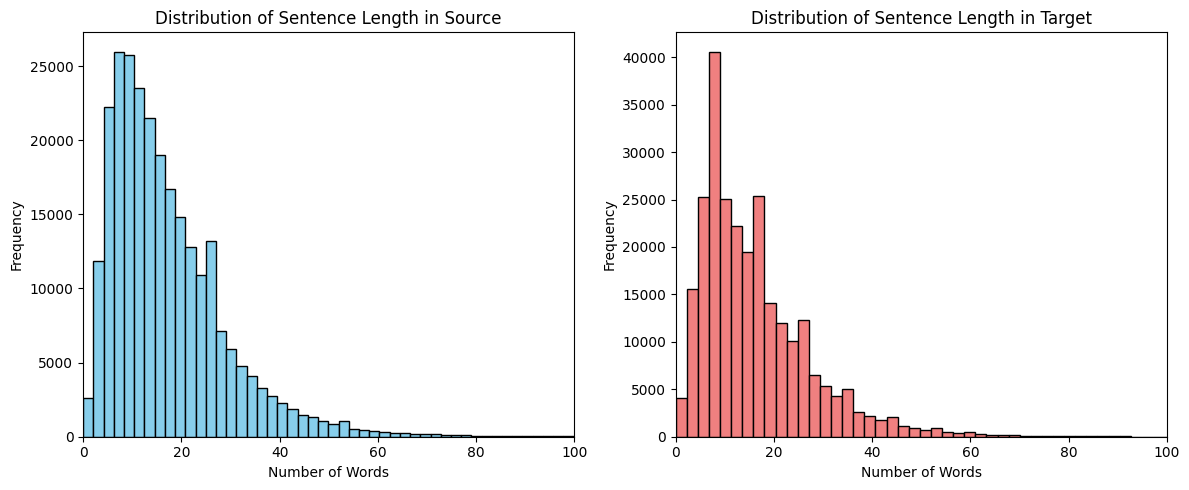

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the first subplot for Source
ax1.hist(word_count_source, bins=300, color='skyblue', edgecolor='black')
ax1.set_xlabel('Number of Words')
ax1.set_ylabel('Frequency')
ax1.set_xlim(0, 100)
ax1.set_title('Distribution of Sentence Length in Source')

# Plot the second subplot for Target
ax2.hist(word_count_target, bins=300, color='lightcoral', edgecolor='black')
ax2.set_xlabel('Number of Words')
ax2.set_ylabel('Frequency')
ax2.set_xlim(0, 100)
ax2.set_title('Distribution of Sentence Length in Target')

# Adjust spacing between subplots
plt.tight_layout()

# Show the subplots
plt.show()

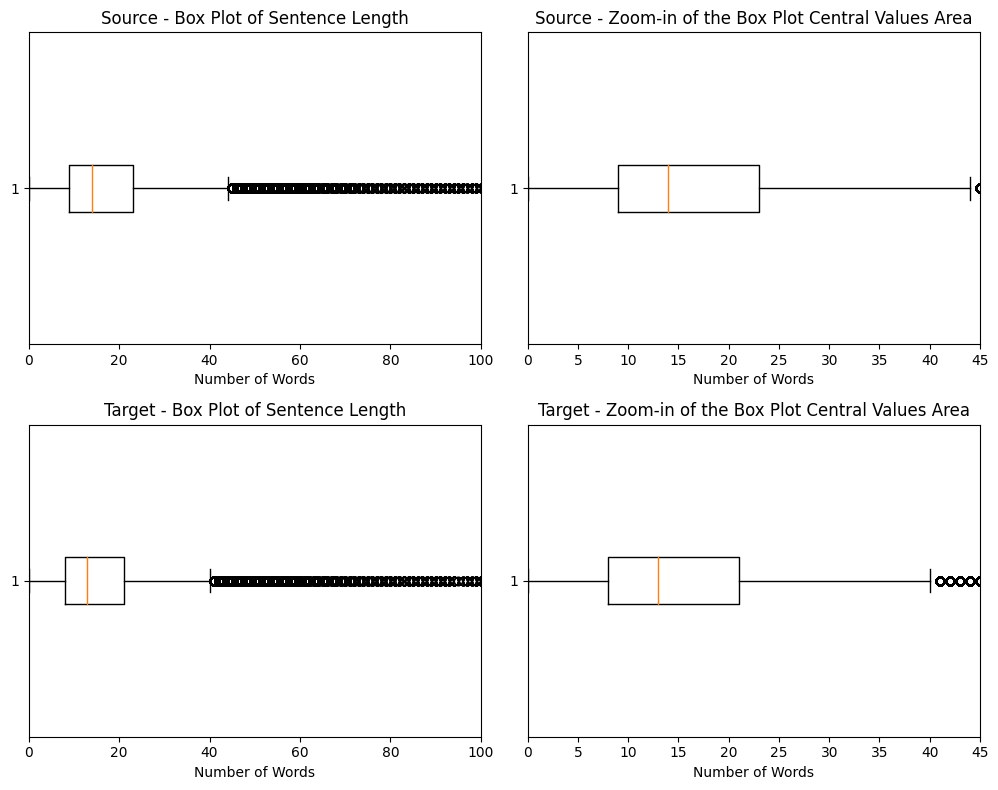

In [ ]:
# Create subplots with 2 rows and 2 columns
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Plot the first box plot for source in the 1st row, 1st column
axs[0, 0].boxplot(word_count_source, vert=False)
axs[0, 0].set_xlabel('Number of Words')
axs[0, 0].set_xlim(0, 100)
axs[0, 0].set_title('Source - Box Plot of Sentence Length')

# Plot the second box plot for source with zoom in the 1st row, 2nd column
axs[0, 1].boxplot(word_count_source, vert=False)
axs[0, 1].set_xlabel('Number of Words')
axs[0, 1].set_xlim(0, 45)
axs[0, 1].set_title('Source - Zoom-in of the Box Plot Central Values Area')

# Plot the first box plot for target in the 2nd row, 1st column
axs[1, 0].boxplot(word_count_target, vert=False)
axs[1, 0].set_xlabel('Number of Words')
axs[1, 0].set_xlim(0, 100)
axs[1, 0].set_title('Target - Box Plot of Sentence Length')

# Plot the second box plot for target with zoom in the 2nd row, 2nd column
axs[1, 1].boxplot(word_count_target, vert=False)
axs[1, 1].set_xlabel('Number of Words')
axs[1, 1].set_xlim(0, 45)
axs[1, 1].set_title('Target - Zoom-in of the Box Plot Central Values Area')

# Adjust layout
plt.tight_layout()
plt.show()

#Remove sentences with sentence length <=6 tokens and >=40 tokens

In [ ]:
# Iterate through the DataFrame and filter based on word count criteria to find and remove the sentences which are too long/short
deleted_indices=[]
num_rows = df1.shape[0]
print('Number of sentences before the removal of too short/long ones:', num_rows)

for index, row in df1.iterrows():
    source_word_count = count_tokenized_words(row['Source'])
    if 6 <= source_word_count <= 40:                   ### OUR PARAMETERS
        # Keep the row in the original DataFrame
        continue
    else:
        # Add the index to the list of deleted indices
        deleted_indices.append(index)

# Remove the deleted rows from the original DataFrame
df1.drop(deleted_indices, inplace=True)
# Count the number of rows using shape attribute
num_rows = df1.shape[0]

print('Number of sentences after the removal of too short/long ones:', num_rows)

Number of sentences before the removal of too short/long ones: 262479
Number of sentences after the removal of too short/long ones: 225512


#Check capitalisation (if 50% of the words in the sentence start with a capital letter, remove the sentence)

In [ ]:
identified_count = 0

# Iterate through each row in the DataFrame
for index, row in df1.iterrows():
    source_sentence = row['Source']
    target_sentence = row['Target_el']

    # Count the total number of words and the number of words with a capitalized first letter in each column
    source_total_words = len(source_sentence)
    source_capitalized_count = sum(1 for word in source_sentence if is_first_letter_capitalized(word))
    target_total_words = len(target_sentence)
    target_capitalized_count = sum(1 for word in target_sentence if is_first_letter_capitalized(word))

    # If more than 50% of the words in either column have capitalized first letters, remove the row
    if source_capitalized_count / source_total_words > 0.5 or target_capitalized_count / target_total_words > 0.5:
        print(f'Source: {" ".join(source_sentence)}')
        print(f'Target: {" ".join(target_sentence)}')
        print()  # Print an empty line for separation

        # Remove the row from the DataFrame
        # df = df.drop(index)
        identified_count += 1  # Increment the identified count

# Print the total count of identified source-target pairs
print(f"Total identified source-target pairs with more than 50% capitalized words: {identified_count}")
# Print the updated DataFrame without the removed rows
# print("Updated DataFrame:")
# print(df)





#Checking if there are latin characters in the target_el column

In [ ]:
# Create an empty list to store the indices of deleted rows
deleted_indices = []

# Iterate through the DataFrame and filter based on Latin characters
for index, row in df1.iterrows():
    if contains_latin(row['Target_el']):
        # If Latin characters are found, add the index to the list of deleted indices
        deleted_indices.append(index)

# Remove the rows with Latin characters in 'Target_el' from the DataFrame
df1 = df1[~df1['Target_el'].apply(contains_latin)]

num_rows = df1.shape[0]

print('Number of paired sentences after the removal latin characters in the target_el_text:', num_rows)

# Print the indices of deleted rows
print('Indices of deleted rows:', deleted_indices)


Number of paired sentences after the removal latin characters in the target_el_text: 213679
Indices of deleted rows: [5, 14, 18, 25, 27, 40, 66, 68, 85, 87, 88, 147, 148, 152, 158, 163, 165, 173, 178, 189, 199, 201, 207, 213, 238, 246, 247, 248, 251, 263, 269, 271, 277, 278, 280, 282, 290, 291, 294, 295, 297, 349, 358, 372, 427, 533, 556, 560, 754, 806, 825, 837, 839, 841, 888, 909, 1004, 1039, 1041, 1044, 1053, 1084, 1138, 1139, 1145, 1146, 1162, 1164, 1182, 1184, 1186, 1190, 1200, 1400, 1411, 1413, 1501, 1510, 1629, 1741, 1756, 1768, 1769, 2037, 2041, 2042, 2089, 2114, 2115, 2156, 2162, 2169, 2170, 2402, 2451, 2452, 2454, 2472, 2491, 2561, 2639, 2681, 2705, 2707, 2726, 2931, 2974, 3150, 3173, 3201, 3206, 3211, 3220, 3292, 3387, 3391, 3402, 3410, 3411, 3427, 3432, 3434, 3436, 3442, 3462, 3486, 3489, 3492, 3497, 3513, 3519, 3550, 3575, 3578, 3587, 3630, 3676, 3806, 3972, 3980, 3982, 3987, 3988, 3990, 3993, 3999, 4011, 4025, 4032, 4072, 4074, 4076, 4086, 4090, 4114, 4141, 4144, 4148, 41

#Hypothesis testing


We wanted to check if the difference of the mean sentece length between the source and the target language is statistically significant. For this we can conduct a paired t-test. A paired t-test calculates the difference between paired observations (in our case: source and target language sentences) and then performs a 1-sample t-test on the differences.

So:
h0: μ=0 :the difference of the means of the dependent groups is 0, so the means of the two samples are comparable.

h1: μ !=0 : the difference of the means is not 0, so the means are not comparable for two groups


In [ ]:
#import pandas as pd
from scipy import stats

# Assuming you have a DataFrame named 'df1' with 'Source' and 'Target_el' columns

# Create an empty list to store the p-values for each pair
p_values = []

# Iterate through each row of the DataFrame
for index, row in df1.iterrows():
    source_sentence = row['Source']
    target_sentence = row['Target_el']

    # Calculate the word counts for the source and target sentences
    source_word_count = len(source_sentence)
    target_word_count = len(target_sentence)

    # Perform a two-sample t-test to compare the word counts
    _, p_value = stats.ttest_ind(source_word_count, target_word_count)

    # Append the p-value to the list
    p_values.append(p_value)

# Set a significance level (e.g., 0.05)
alpha = 0.05

# Determine statistical significance for each pair
statistically_significant = [p < alpha for p in p_values]

# Create a new column in the DataFrame to indicate statistical significance
df1['Statistically_Significant'] = statistically_significant

# Print the DataFrame to see the results
print(df1)

## Performing T-Test : example from sentiment analysis
#from scipy import stats

#df_train['text_length'] = df_train['text'].apply(lambda t: len(str(t)))

#positive_text_lengths = df_train[df_train['sentiment'] == 'positive']['text_length']
#negative_text_lengths = df_train[df_train['sentiment'] == 'negative']['text_length']
#neutral_text_lengths = df_train[df_train['sentiment'] == 'neutral']['text_length']

# Perform ANOVA test
#f_statistic, p_value = stats.f_oneway(positive_text_lengths, negative_text_lengths, neutral_text_lengths)

# Print the results
#print("ANOVA Test Results:")
#print(f"F-statistic: {f_statistic}")
#print(f"P-value: {p_value}")

# Interpret the results
#alpha = 0.05  # Set your significance level
#if p_value < alpha:
#    print("The means of at least two groups are significantly different.")
#else:
#    print("There is no significant difference in the means of the groups.")

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:7030: RuntimeWarning: invalid value encountered in double_scalars
  svar = ((n1 - 1) * v1 + (n2 - 1) * v2) / df


                                                   Source  \
1       [And, it's, truly, a, great, honor, to, have, ...   
2       [I, have, been, blown, away, by, this, confere...   
3       [And, I, say, that, sincerely,, partly, becaus...   
5       [I, flew, on, Air, Force, Two, for, eight, yea...   
6       [Now, I, have, to, take, off, my, shoes, or, b...   
...                                                   ...   
262654  [It, was, indeed, true, that, the, stories, of...   
262655  [My, work, speaks, for, those, who, will, no, ...   
262656  [Today,, we, stand, ready, to, tell, our, own,...   
262657  [But, the, question, still, remains:, are, you...   
262658  [I, hope, you, are,, because, we, are, coming,...   

                                                Target_el  \
1       [Και, πρόκειται, για, μια, πραγματικά, μεγάλη,...   
2       [Με, έχει, συνεπάρει, η, διοργάνωση,, και, θελ...   
3       [Και, το, λέω, ειλικρινά,, επειδή, εν, μέρει, ...   
5       [Πέταγα, με, το

In [ ]:
import numpy as np

In [ ]:
#obviously the lengths are the same
source_sentence = df1['Source']
target_sentence = df1['Target_el']
source =len(source_sentence)
target = len(target_sentence)

print(source_sentence)
print(target_sentence)

diffs = source - target
print("mean of diffs:",np.mean(diffs))
print("diffs", diffs)

1         [And, it's, truly, a, great, honor, to, have, ...
2         [I, have, been, blown, away, by, this, confere...
3         [And, I, say, that, sincerely,, partly, becaus...
5         [I, flew, on, Air, Force, Two, for, eight, yea...
6         [Now, I, have, to, take, off, my, shoes, or, b...
                                ...                        
262654    [It, was, indeed, true, that, the, stories, of...
262655    [My, work, speaks, for, those, who, will, no, ...
262656    [Today,, we, stand, ready, to, tell, our, own,...
262657    [But, the, question, still, remains:, are, you...
262658    [I, hope, you, are,, because, we, are, coming,...
Name: Source, Length: 225512, dtype: object
1         [Και, πρόκειται, για, μια, πραγματικά, μεγάλη,...
2         [Με, έχει, συνεπάρει, η, διοργάνωση,, και, θελ...
3         [Και, το, λέω, ειλικρινά,, επειδή, εν, μέρει, ...
5         [Πέταγα, με, το, Air, Force, Two, για, οχτώ, χ...
6         [Τώρα, πρέπει, να, βγάζω, τα, παπούτσια, μου, 

#Remove sentence pairs with n+ token difference

In [ ]:
# Create an empty list to store the indices of rows with a difference of 5 tokens or more
remove_indices = []

# Create a counter for sentences with a difference of exactly 5 tokens
count_5_tokens_difference = 0

# Set the threshold for the difference
threshold = 5

# Iterate through each row in the DataFrame
for index, row in df1.iterrows():
    source_length = word_count_source.loc[index, 'Source']
    target_length = word_count_target.loc[index, 'Target_el']
    length_difference = abs(source_length - target_length)

    # Check if the length difference is greater than or equal to the threshold
    if length_difference >= threshold:
        # Print the sentence pair before removing
        print(f"Sentence pair with a difference of {length_difference} tokens detected in row {index}:")
        print(f"Source sentence: {row['Source']}")
        print(f"Target sentence: {row['Target_el']}\n")
        remove_indices.append(index)

    if length_difference >= threshold:
        count_5_tokens_difference += 1

# Remove rows with a difference of 5 tokens or more
#df1 = df1.drop(remove_indices)

# Print the indices of removed rows
#print("Indices of removed rows:", remove_indices)

# Print the total count of sentence pairs with 5 or more tokens difference
print(f"Total sentence pairs with 5 or more tokens difference: {count_5_tokens_difference}")


#Collect final dataframes in one

In [ ]:
# Merge the DataFrames based on indices
chosen_ones = df[df.index.isin(df1.index)]

# Resulting merged DataFrame will contain rows with indices present in smaller_df. BUT WE HAVE UNPROCESSED SENTENCES (WITH PARENTHESES)
chosen_ones.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213679 entries, 1 to 262658
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Source     213679 non-null  object
 1   Target_el  213679 non-null  object
dtypes: object(2)
memory usage: 4.9+ MB


In [ ]:
chosen_ones[10: 20]

,Source,Target_el
15,"(Laughter) It was dinnertime, and we started l...",Ήταν ώρα για δείπνο και ψάχναμε μέρος να φάμε.
17,"We got to Exit 238, Lebanon, Tennessee.","Πήραμε την Έξοδο 238, για Λίβανο, Τενεσή."
19,"Low-cost family restaurant chain, for those of...","Φτηνή οικογενειακή αλυσίδα εστιατορίων, για όσ..."
20,"We went in and sat down at the booth, and the ...","Μπήκαμε μέσα και καθήσαμε στο τραπέζι, ήρθε η ..."
21,"(Laughter) She took our order, and then went t...","(Γέλια) Πήρε την παραγγελία μας, και πήγε στο ..."
22,"And she said ""Yes, that's former Vice Presiden...","Την άκουσα να λέει, «Ναι, είναι ο πρώην Αντιπρ..."
23,"And the man said, ""He's come down a long way, ...","Και ο άντρας στο τραπέζι σχολίασε, «Έχει πέσει..."
24,(Laughter) (Applause) There's been kind of a s...,Πρόκειται για μία σειρά διαδοχικών συνειδητοπο...
26,And I began the speech by telling them the sto...,Και ξεκίνησα να τους λέω την ιστορία του τι εί...
28,"I gave my speech, then went back out to the ai...","Τελείωσα με τον λόγο μου, και επέστρεψα στο αε..."


#TMX Parsing in EL_RU

In [ ]:
# Parse the TMX file with Russian translation
tree_ru = ET.parse('/content/drive/MyDrive/Machine_Translation/el-ru.tmx')
root_ru = tree_ru.getroot()

In [ ]:
# Initialize counters for source and target elements
source_count = 0
target_count = 0

source = []
target = []

# Define the XML namespace
xml_namespace = 'http://www.w3.org/XML/1998/namespace'

# Iterate through translation units and extract source and target text. We suppose that the Source language is English and the target is eithe Greek or Russan
for tu in root_ru.findall('.//tu'):
    source_tuv = tu.find('.//tuv[@{%s}lang="el"]/seg' % xml_namespace)
    target_tuv = tu.find('.//tuv[@{%s}lang="ru"]/seg' % xml_namespace)

    if source_tuv is not None:
        source_text = source_tuv.text
        source_count += 1
        source.append(source_text)

    if target_tuv is not None:
        target_text = target_tuv.text
        target_count += 1
        target.append(target_text)

# Print the total number of source and target elements
print('Number of Greek Elements:', source_count)
print('Number of Target Elements (Russian):', target_count)


# Probably we would work with frames
# Our column names
column_names = ['Greek', 'Target_ru']

# Create a DataFrame
data = list(zip(source, target))
df_ru = pd.DataFrame(data, columns=column_names)

#Remove parentheses
# df_ru.iloc[:, 1] = df_ru.iloc[:, 1].str.replace(r'\(.*?\)', '')

Number of Greek Elements: 257784
Number of Target Elements (Russian): 257784


<ipython-input-24-5ecf33d620dd>:39: FutureWarning: The default value of regex will change from True to False in a future version.
  df_ru.iloc[:, 1] = df_ru.iloc[:, 1].str.replace(r'\(.*?\)', '')


#Drop duplicates in the EL_RU dataset

In [ ]:
df_ru = df_ru.drop_duplicates(subset=['Greek'])
df_ru.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 256479 entries, 0 to 257783
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Greek      256478 non-null  object
 1   Target_ru  256478 non-null  object
dtypes: object(2)
memory usage: 5.9+ MB


#Merge the original dataframes en_el and el_ru, based on the content of column 'Target_el'.
If the content of column 'Target_el' of the en_el dataset is the same with the content of column 'Greek' of the el_ru dataset, then we keep this sentence. That's how we end up with the chosen trinity!

In [ ]:
chosen_trinity = pd.merge(chosen_ones, df_ru[['Greek', 'Target_ru']], how='left', left_on='Target_el', right_on='Greek')

# Drop the unnecessary 'Greek' column if needed
chosen_trinity.drop(['Greek'], axis=1, inplace=True)

chosen_trinity.dropna(subset=['Target_ru'], inplace=True)
# Print the resulting DataFrame with the merged content
print(chosen_trinity)
chosen_trinity.shape[0]

                                                   Source  \
0       And it's truly a great honor to have the oppor...   
1       I have been blown away by this conference, and...   
2       And I say that sincerely, partly because (Mock...   
3       (Laughter) Now I have to take off my shoes or ...   
4       (Laughter) (Applause) I'll tell you one quick ...   
...                                                   ...   
213674  It was indeed true that the stories of history...   
213675  My work speaks for those who will no longer le...   
213676  Today, we stand ready to tell our own stories ...   
213677  But the question still remains: are you prepar...   
213678  I hope you are, because we are coming regardle...   

                                                Target_el  \
0       Και πρόκειται για μια πραγματικά μεγάλη τιμή π...   
1       Με έχει συνεπάρει η διοργάνωση, και θελω να ευ...   
2       Και το λέω ειλικρινά, επειδή εν μέρει - (Ψεύτι...   
3       Τώρα πρέπει να 

209516

In [ ]:
chosen_trinity.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 209516 entries, 0 to 213678
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Source     209516 non-null  object
 1   Target_el  209516 non-null  object
 2   Target_ru  209516 non-null  object
dtypes: object(3)
memory usage: 6.4+ MB


In [ ]:
## DROP PARENTHESES IN ALL OUR DATA
for column in chosen_trinity.columns:
    chosen_trinity[column] = chosen_trinity[column].str.replace(r'\(.*?\)', '')

<ipython-input-28-25b23c05eeaf>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  chosen_trinity[column] = chosen_trinity[column].str.replace(r'\(.*?\)', '')


In [ ]:
chosen_trinity = chosen_trinity[~chosen_trinity.iloc[:, 1].apply(contains_latin)]
num_rows = chosen_trinity.shape[0]
print('Number of paired sentences after the removal latin characters in the Greek target text:', num_rows)

chosen_trinity = chosen_trinity[~chosen_trinity.iloc[:, 2].apply(contains_latin)]
num_rows = chosen_trinity.shape[0]
print('Number of paired sentences after the removal latin characters in the Russian target text:', num_rows)

Number of paired sentences after the removal latin characters in the Greek target text: 209516
Number of paired sentences after the removal latin characters in the Russian target text: 206580


# COSINE SIMILARITY

Apply cosine similarity on the sentence embeddings of the cleaned dataset to validate our findings and possibly remove any last mistankes, now in terms of semantic similarity.
Since we have senteces, the SBERT can be a good embedding representation
https://www.sbert.net/examples/training/multilingual/README.html

### Now we can make final calculations for cosine similarity for the chosen sentences in the three languages and apply the final cleaning based on the results

In [ ]:
!pip install sentence-transformers
from sentence_transformers import SentenceTransformer
embedder = SentenceTransformer('distiluse-base-multilingual-cased-v2') #multilingual model with automatic language detection
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [ ]:
###working example for embeddings
#emb1 = embedder.encode('Κάναμε αυτό το πείραμα με μία ομάδα ασθενών που είχαν δευτεροπαθή αμνησία και νοσηλεύονται στο νοσοκομείο.')
#emb2 = embedder.encode('They drank way too much, and they can\'t make new memories.')

#emb1 = emb1.reshape(1, -1)
#emb2 = emb2.reshape(1, -1)

#similarity_score = cosine_similarity(emb1, emb2)[0][0]

#print('Cosine similarity of the given sentences: ', similarity_score)

In [ ]:
# Extract sentences from the DataFrame
sentences_column1 = chosen_trinity['Source'].tolist()
sentences_column2 = chosen_trinity['Target_el'].tolist()
sentences_column3 = chosen_trinity['Target_ru'].tolist()


# Calculate embeddings for the columns of sentences
embeddings_column1 = embedder.encode(sentences_column1)
embeddings_column2 = embedder.encode(sentences_column2)
embeddings_column3 = embedder.encode(sentences_column3)


#Emedding similarity of EN_EL

In [ ]:
# Calculate cosine similarity for pairs of sentences in each row
cosine_similarity_scores = []
for emb1, emb2 in zip(embeddings_column1, embeddings_column2):
    # Reshape the embeddings to be 2D arrays before calculating cosine similarity
    emb1 = emb1.reshape(1, -1)
    emb2 = emb2.reshape(1, -1)

    # Calculate cosine similarity
    similarity_score = cosine_similarity(emb1, emb2)[0][0]

    # Append similarity score to the list
    cosine_similarity_scores.append(similarity_score)

# Add the cosine similarity scores as a new column in the DataFrame
chosen_trinity['Cosine_Similarity_en_el'] = cosine_similarity_scores

#Embedding similarity EN_RU

In [ ]:
# Calculate cosine similarity for pairs of sentences in each row
cosine_similarity_scores = []
for emb1, emb2 in zip(embeddings_column1, embeddings_column3):
    # Reshape the embeddings to be 2D arrays before calculating cosine similarity
    emb1 = emb1.reshape(1, -1)
    emb2 = emb2.reshape(1, -1)

    # Calculate cosine similarity
    similarity_score = cosine_similarity(emb1, emb2)[0][0]

    # Append similarity score to the list
    cosine_similarity_scores.append(similarity_score)

# Add the cosine similarity scores as a new column in the DataFrame
chosen_trinity['Cosine_Similarity_en_ru'] = cosine_similarity_scores

#Embedding similarity EL_RU

In [ ]:
# Calculate cosine similarity for pairs of sentences in each row
cosine_similarity_scores = []
for emb1, emb2 in zip(embeddings_column2, embeddings_column3):
    # Reshape the embeddings to be 2D arrays before calculating cosine similarity
    emb1 = emb1.reshape(1, -1)
    emb2 = emb2.reshape(1, -1)

    # Calculate cosine similarity
    similarity_score = cosine_similarity(emb1, emb2)[0][0]

    # Append similarity score to the list
    cosine_similarity_scores.append(similarity_score)

# Add the cosine similarity scores as a new column in the DataFrame
chosen_trinity['Cosine_Similarity_el_ru'] = cosine_similarity_scores

#Rank pairs by their multilingual embedding cosine similarity score.
So our condition here can be that any pairs that have a similarity score close to 0 or a negative score, then these cases should be removed.

In [ ]:
ranked_dataframe = chosen_trinity.sort_values(by='Cosine_Similarity_el_ru',ascending=False)
ranked_dataframe[203000:]


,Source,Target_el,Target_ru,Cosine_Similarity_en_el,Cosine_Similarity_en_ru,Cosine_Similarity_el_ru
159180,And you can see how dense the population is.,Και μπορείτε να δείτε πόσο πυκνός είναι ο πληθ...,"Смотрите, какая здесь насыщенная жизнь!",0.897916,0.297208,0.395557
139310,"This is also a dramatization, in case that's n...",Αυτή η περιγραφή είναι απλουστευμένη.,"Это драматизация, если не совсем ясно.",0.310976,0.867315,0.395555
183062,I don't think there is a third option.,Δεν νομίζω πως υπάρχει τρίτη επιλογή.,"Я не думаю, что есть что-то еще кроме саванны ...",0.952901,0.380735,0.395535
34844,"But introverts, you being you, you probably ha...","Αλλά εσωστρεφείς, όντας εσείς, ίσως έχετε την ...",Однако интровертам обычно свойственно тщательн...,0.759506,0.656608,0.395522
60354,So what do we need if we want to do this at th...,Τι χρειαζόμαστε λοιπόν για να το κάνουμε αυτό ...,Как же перенести этот механизм в большой масшт...,0.935370,0.351348,0.395467
...,...,...,...,...,...,...
173753,And what's so neat about it is how you accept ...,Και το θαυμάσιο εδώ είναι το πως δέχεστε αυτή ...,,0.799148,-0.100988,-0.084361
50862,I don't know if you know this.,Δεν ξέρω αν το ξέρετε αυτό.,В современной физике появилось много сторонник...,0.963613,-0.078543,-0.085555
153977,"And it is necessary, no matter how fragile or ...","Και είναι απαραίτητο, ανεξάρτητα με το πόσο εύ...",На большей части земного шара государство восп...,0.784227,-0.066154,-0.085788
179406,But I think the man was maybe 25 years too ear...,νομίζω ότι ο άνθρωπος ήταν ίσως 25 χρόνια μπρο...,Благодарю Вас.,0.780081,-0.099151,-0.105288


#Chosen threshold cosine score for keeping a row is 0.47 for both en-el and el_ru embedding combinations

In [ ]:
# Create a condition to filter rows with non-negative values in both columns
condition = (chosen_trinity['Cosine_Similarity_en_el'] >= 0.47) & (chosen_trinity['Cosine_Similarity_en_ru'] >= 0.47)

# Apply the condition to filter the DataFrame
filtered_df = chosen_trinity[condition]
filtered_df.sort_values(by='Cosine_Similarity_en_ru',ascending=False)

,Source,Target_el,Target_ru,Cosine_Similarity_en_el,Cosine_Similarity_en_ru,Cosine_Similarity_el_ru
56858,We can all change the world.,Όλοι μπορούμε ν' αλλάξουμε τον κόσμο.,Мы все можем изменить мир.,0.981149,0.994057,0.986257
39599,"""I don't want to go to school today.",«Δε θέλω να πάω σήμερα στο σχολείο.,«Я не хочу идти в школу сегодня.,0.987765,0.993976,0.992770
75561,"In the United States, for example, more than 7...","Στις ΗΠΑ, για παράδειγμα, περισσότερα από 70 ε...","В США, например, более чем 70 миллионов новых ...",0.967785,0.993866,0.978117
199950,But I know where she was.,Αλλά ξέρω πού ήταν.,"Но я знаю, где она была.",0.956628,0.993278,0.968728
34406,I want to talk to you about fear.,Θέλω να σας μιλήσω για τον φόβο.,Я хочу поговорить с вами о страхе.,0.987568,0.992999,0.985319
...,...,...,...,...,...,...
102033,Did you feel I influenced you in any decision?,Νιώσατε ότι σας επηρέασα σε κάποια απόφαση;,Я каким-то образом влиял на любой из ответов?,0.950007,0.470047,0.423328
103881,"Now, on a bit of a comical note here is that o...","Μια κωμική σημείωση εδώ, η Ροζέτα αρχικά είχε ...","Комичность ситуации в том, что изначально «Роз...",0.759824,0.470045,0.578543
150712,"The classifier was pretty good, but not as goo...","Η ταξιθέτηση είναι αρκετά καλή, μα όχι τόσο όσ...","И он неплохо справлялся, но до человека ему бы...",0.541800,0.470039,0.395656
59680,This means that people in my group were doing ...,Αυτό σημαίνει ότι τα μέλη της ομάδας μου κάναμ...,Нашей команде пришлось очень много пылесосить ...,0.743156,0.470037,0.476531



#Select columns on the cleaned text in the source and the 2 target languages and save it in a .csv file.

In [ ]:
path='/content/drive/MyDrive/Machine_Translation/Assignment_1/deliverables/generic/generic.csv'

In [ ]:
selected_columns = filtered_df[['Source', 'Target_el', 'Target_ru']]

# Save the selected columns to a CSV file named 'generic.csv'
selected_columns.to_csv(path, index=False,encoding='utf-8')


In [ ]:
d=pd.read_csv('/content/drive/MyDrive/Machine_Translation/Assignment_1/deliverables/generic/generic.csv')
d

,Source,Target_el,Target_ru
0,And it's truly a great honor to have the oppor...,Και πρόκειται για μια πραγματικά μεγάλη τιμή π...,"Это огромная честь, получить возможность выйти..."
1,"I have been blown away by this conference, and...","Με έχει συνεπάρει η διοργάνωση, και θελω να ευ...","Я в восторге от этой конференции, и я хочу поб..."
2,"And I say that sincerely, partly because I ne...","Και το λέω ειλικρινά, επειδή εν μέρει - - το ...","И я говорю это от всего сердца, потому что... ..."
3,Now I have to take off my shoes or boots to g...,Τώρα πρέπει να βγάζω τα παπούτσια μου κάθε φορ...,Теперь мне приходится снимать ботинки перед по...
4,I'll tell you one quick story to illustrate ...,Θα σας πω μία μικρή ιστορία για να καταλάβετ...,"Я расскажу маленькую историю о том, каково м..."
...,...,...,...
200284,It was indeed true that the stories of history...,Ήταν πράγματι αλήθεια ότι οι αφηγήσεις της ιστ...,"Это на самом деле было так, что история писала..."
200285,My work speaks for those who will no longer le...,Το έργο μου εκπροσωπεί όλους όσους δεν επιτρέπ...,"В своей работе я говорю о тех, кто формирует с..."
200286,"Today, we stand ready to tell our own stories ...",Σήμερα είμαστε έτοιμοι να αρθρώσουμε τις δικές...,Сегодня мы готовы рассказать наши истории без ...
200287,But the question still remains: are you prepar...,"Ωστόσο, το ερώτημα παραμένει: είστε προετοιμασ...","Но вопрос остаётся: готовы ли вы услышать то, ..."


#Store the content of each column in a separate .txt file for moses training

In [ ]:
csv_trouli = '/content/drive/MyDrive/Machine_Translation/generic/generic.csv'

df = pd.read_csv(csv_trouli)

# df['Source'] = df['Source'].str.strip()
# df['Source'] = re.sub(' +', ' ',df['Source'])
# df['Target_el'] = df['Target_el'].str.strip()
# df['Target_el'] = re.sub(' +', ' ',df['Target_el'])
# df['Target_ru'] = df['Target_ru'].str.strip()
# df['Target_ru'] = re.sub(' +', ' ',df['Target_ru'])

print(df.head)

output = '/content/drive/MyDrive/Machine_Translation/generic/'

def clean_text(text):
    # Remove leading and trailing spaces
    text = text.strip()
    # Replace multiple spaces with a single space
    text = re.sub(' +', ' ', text)
    return text


for column_name in df.columns:
    df[column_name] = df[column_name].apply(clean_text)

for column_name, column_data in df.items():
    # Define the full file path for the .txt file
    file_path = f"{output}{column_name}.txt"

    # Extract the column data as a Series and convert it to a string
    column_text = column_data.str.cat(sep='\n')

    # Write the column data to the .txt file with UTF-8 encoding
    with open(file_path, 'w', encoding='utf-8') as txt_file:
        txt_file.write(column_text)

    print(f"Saved column '{column_name}' to: {file_path}")

In [ ]:
import pandas as pd
df=pd.read_csv('/content/drive/MyDrive/Machine_Translation/Assignment_1/deliverables/generic/generic.csv')
df

,Source,Target_el,Target_ru
0,And it's truly a great honor to have the oppor...,Και πρόκειται για μια πραγματικά μεγάλη τιμή π...,"Это огромная честь, получить возможность выйти..."
1,"I have been blown away by this conference, and...","Με έχει συνεπάρει η διοργάνωση, και θελω να ευ...","Я в восторге от этой конференции, и я хочу поб..."
2,"And I say that sincerely, partly because I ne...","Και το λέω ειλικρινά, επειδή εν μέρει - - το ...","И я говорю это от всего сердца, потому что... ..."
3,Now I have to take off my shoes or boots to g...,Τώρα πρέπει να βγάζω τα παπούτσια μου κάθε φορ...,Теперь мне приходится снимать ботинки перед по...
4,I'll tell you one quick story to illustrate ...,Θα σας πω μία μικρή ιστορία για να καταλάβετ...,"Я расскажу маленькую историю о том, каково м..."
...,...,...,...
200284,It was indeed true that the stories of history...,Ήταν πράγματι αλήθεια ότι οι αφηγήσεις της ιστ...,"Это на самом деле было так, что история писала..."
200285,My work speaks for those who will no longer le...,Το έργο μου εκπροσωπεί όλους όσους δεν επιτρέπ...,"В своей работе я говорю о тех, кто формирует с..."
200286,"Today, we stand ready to tell our own stories ...",Σήμερα είμαστε έτοιμοι να αρθρώσουμε τις δικές...,Сегодня мы готовы рассказать наши истории без ...
200287,But the question still remains: are you prepar...,"Ωστόσο, το ερώτημα παραμένει: είστε προετοιμασ...","Но вопрос остаётся: готовы ли вы услышать то, ..."


In [ ]:
# Shuffling the original dataset
shuffled_original = df.sample(frac=1)

# Save the shuffled original dataset to a new CSV file
shuffled_original.to_csv('/content/drive/MyDrive/Machine_Translation/Assignment_2/Subtask_2/shuffled_generic.csv', index=False)

# Save the first 1000 rows of the shuffled original dataset to a new CSV file
#shuffled_original.head(1000).to_csv('/content/drive/MyDrive/Machine_Translation/Assignment_2/Subtask_2/shuffled_generic_1000.csv', index=False)


In [ ]:
import re
#output = '/content/drive/MyDrive/Machine_Translation/Assignment_2/Subtask_2/'

def clean_text(text):
    # Remove leading and trailing spaces
    text = text.strip()
    # Replace multiple spaces with a single space
    text = re.sub(' +', ' ', text)
    return text


#for column_name in shuffled_1000.columns:
#    shuffled_1000[column_name] = shuffled_1000[column_name].apply(clean_text)

#for column_name, column_data in shuffled_1000.items():
    # Define the full file path for the .txt file
#    file_path = f"{output}{column_name}.txt"

    # Extract the column data as a Series and convert it to a string
#    column_text = column_data.str.cat(sep='\n')

    # Write the column data to the .txt file with UTF-8 encoding
#    with open(file_path, 'w', encoding='utf-8') as txt_file:
#        txt_file.write(column_text)

#    print(f"Saved column '{column_name}' to: {file_path}")

Saved column 'Source' to: /content/drive/MyDrive/Machine_Translation/Assignment_2/Subtask_2/Source.txt
Saved column 'Target_el' to: /content/drive/MyDrive/Machine_Translation/Assignment_2/Subtask_2/Target_el.txt
Saved column 'Target_ru' to: /content/drive/MyDrive/Machine_Translation/Assignment_2/Subtask_2/Target_ru.txt


In [ ]:
shuffled_generic=pd.read_csv('/content/drive/MyDrive/Machine_Translation/Assignment_2/Subtask_2/en_el/shuffled_generic.csv')
shuffled_generic.info

<bound method DataFrame.info of                                                    Source  \
0       Others we randomly assign to procrastinate by ...   
1       I've worked with plants, bacteria, cuttlefish,...   
2       The issue of asylum seekers in Australia has b...   
3       Which means that no matter how destructive and...   
4                           So you think of these areas.    
...                                                   ...   
200284  What if we experimented with creating that kin...   
200285  And one wonders, could this populism have been...   
200286  So I'd like to encourage you to pay attention ...   
200287  After that, I started to experiment with vario...   
200288  The story starts in Kenya in December of 2007,...   

                                                Target_el  \
0       Σε κάποιους άλλους ζητήσαμε να είναι αναβλητικ...   
1       Έχω δουλέψει με φυτά, βακτήρια, σουπιές, φρουτ...   
2       Το ζήτημα των αιτούντων ασύλου στην Αυστραλί

In [ ]:
from sklearn.model_selection import train_test_split

train,temp=train_test_split(shuffled_generic, test_size=0.02)
dev, tune= train_test_split(temp,test_size=0.125)
train.to_csv('train.csv', index=False)
dev.to_csv('dev.csv',index=False)
tune.to_csv('tune.csv', index=False)
print('Success')

Success


In [ ]:
def split_and_save_dataset(df, train_filename, dev_filename):
    # Splitting the data into train and dev sets
    train, dev  = train_test_split(df, test_size=0.02, random_state=42)

    # Saving train and dev sets to CSV files
    train.to_csv(train_filename, index=False)
    dev.to_csv(dev_filename, index=False)


split_and_save_dataset(shuffled_generic, train_filename='train.csv', dev_filename='dev.csv')

In [ ]:
dev=pd.read_csv('/content/dev.csv')
train=pd.read_csv('/content/train.csv')
tune=pd.read_csv('/content/tune.csv')

#Some data for tuning

In [ ]:
import pandas as pd

# Load your shuffled dataset into a pandas DataFrame (replace 'your_dataset.csv' with your file)
#df = pd.read_csv('/content/drive/MyDrive/Machine_Translation/Assignment_2/Subtask_2/en_el/dev_generic.csv')

# Select the first 450 rows
selected_data = dev.head(450)

# Save the selected data to a new CSV file
selected_data.to_csv('/content/drive/MyDrive/Machine_Translation/Assignment_2/Subtask_2/en_el/dataset_en_el/tuning/tuning.csv', index=False)

# Update the original dataset by removing the selected 450 rows
updated_data = dev.iloc[450:]  # Select all rows starting from 450 to the end

# Save the updated dataset to the original file
updated_data.to_csv('/content/drive/MyDrive/Machine_Translation/Assignment_2/Subtask_2/en_el/dataset_en_el/dev/dev_less.csv', index=False)


In [ ]:
tuning=pd.read_csv('/content/drive/MyDrive/Machine_Translation/Assignment_2/Subtask_2/en_el/dataset_en_el/tuning/tuning.csv')
print(tuning.head())
dev_less=pd.read_csv('/content/drive/MyDrive/Machine_Translation/Assignment_2/Subtask_2/en_el/dataset_en_el/dev/dev_less.csv')
print(dev_less.head())

In [ ]:
import re
def clean_text(text):
    # Remove leading and trailing spaces
    text = text.strip()
    # Replace multiple spaces with a single space
    text = re.sub(' +', ' ', text)
    return text

output = '/content/drive/MyDrive/Machine_Translation/Assignment_2/Subtask_2/en_el/dataset_en_el/dev/'

for column_name in dev.columns:
    dev[column_name] = dev[column_name].apply(clean_text)

for column_name, column_data in dev.items():
    # Define the full file path for the .txt file
    file_path = f"{output}{column_name}.txt"

    # Extract the column data as a Series and convert it to a string
    column_text = column_data.str.cat(sep='\n')

    # Write the column data to the .txt file with UTF-8 encoding
    with open(file_path, 'w', encoding='utf-8') as txt_file:
        txt_file.write(column_text)

    print(f"Saved column '{column_name}' to: {file_path}")

Saved column 'Source' to: /content/drive/MyDrive/Machine_Translation/Assignment_2/Subtask_2/en_el/dataset_en_el/dev/Source.txt
Saved column 'Target_el' to: /content/drive/MyDrive/Machine_Translation/Assignment_2/Subtask_2/en_el/dataset_en_el/dev/Target_el.txt
Saved column 'Target_ru' to: /content/drive/MyDrive/Machine_Translation/Assignment_2/Subtask_2/en_el/dataset_en_el/dev/Target_ru.txt
